# Regression with Pytorch

First we generate random data to test our models.

We generate $m$ random features, $X$ from a Gaussian distribution. We append a column of ones to the front to act as our constant term. We then generate a set of random $m+1$ values to form our model weights.

Then we form our output by creating a linear weighted sum of our features:
$$y_i = \sum_m X_{i,m} * w_m + e_i$$

We have added some Gaussian noise to create some uncertainty around of model estimates.

In [2]:
# %% generate regression data
import numpy as np

# independent features
n = 1000
m = 10
features = np.random.randn(n, m)

X = np.concatenate((np.ones((n, 1)), features), axis=1)
w = np.random.randn(m + 1, 1)
e = np.random.randn(n, 1)
y = X @ w + e

## Statsmodels approach

With `statsmodels` we can apply the ordinary least squares solution to the above data to recover estimates of the weights, $w$.

In [3]:
# %% Linear regression with statsmodels
import statsmodels.api as sm

results = sm.OLS(y, X).fit()
print(results.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1260.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:57:40   Log-Likelihood:                -1394.2
No. Observations:                1000   AIC:                             2810.
Df Residuals:                     989   BIC:                             2864.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1147      0.031     -3.674      0.000      -0.176      -0.053
x

## Pytorch approach

We can solve the same linear regression problem in `pytorch`.

The ordinary least squares method above minimise the negative likelihood function. In this case it is the MSE:
$$loss = \sum_i (y-\hat{y})^2$$
Minimising a function is a generic problem we can solve using the gradient descent method.
This can be implemented by libraries such as pytorch.

The problem is decomposed into a few steps:
* Given an estimate of the model weights, we predict what our output, $y$, should be.
* Calculate a loss function based on the difference between our prediction and the actual output. We use the above MSE function.
* Update the model weights to improve the loss function.
* Iterate the above until the weights have converged.

We will apply this in pytorch.
Pytorch has its own internal memory structures so we need to convert from our numpy arrays to torch tensors using `from_numpy()`. The weights estimates are initialised randomly. We require that the gradients are calculated for the weights so we use the `requires_grad` flag.

We use the stochastic gradient descent optimiser to update the weights, the learning rate needs to be chosen appropriately.

The forward step calculates the output of the network. The loss function is setup using pytorch functions which run over the tensor objects and allow the gradients to be calculated automatically.

The gradients need to be reset each iteration as PyTorch accumulates the gradients on subsequent backward passes. The backwards step calculates the gradients automatically.

The optimizer object then updates the model weights to minimise the loss function.

We iterate over the data 100 times, at which point the weights have converged.

In [4]:
import torch
import torch.optim as optim

X_t = torch.from_numpy(X)
y_t = torch.from_numpy(y)

w_t = torch.randn(m + 1, 1, dtype=torch.float64, requires_grad=True)
learning_rate = 5e-5
optimizer = optim.SGD([w_t], lr=learning_rate, momentum=0.0)
optimizer.zero_grad()

loss_values = []

for t in range(100):
    # Forward pass
    y_pred = X_t.mm(w_t)

    # Compute and print loss
    loss = (y_pred - y_t).pow(2).sum()
    loss_values.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

loss_values = np.array(loss_values)

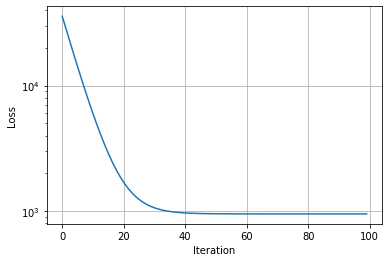

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_values)), loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()

In [8]:
# %% Results weights are equivalent to statsmodels
print(w)
print(w_t.flatten())
print(results.params.flatten())
print(results.summary())

[[-0.10320225]
 [-0.33617011]
 [ 1.56623588]
 [ 0.62967106]
 [-0.06975644]
 [-0.72286406]
 [ 1.03406961]
 [-2.37377423]
 [-0.67402967]
 [ 1.30993798]
 [ 0.61605779]]
tensor([-0.1146, -0.3391,  1.6223,  0.6059, -0.0535, -0.6934,  0.9592, -2.3440,
        -0.6386,  1.3061,  0.5914], dtype=torch.float64,
       grad_fn=<ViewBackward>)
[-0.11465699 -0.33894423  1.62254363  0.60593867 -0.05361139 -0.69352528
  0.95916812 -2.34442931 -0.63884879  1.3061638   0.59139397]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1260.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:58:21   Log-Likelihood:                -1394.2
No. Observations:                1000   AIC:             

## Pyro approach

Need to name the pyro primatives

Pyro enables variational inference.

### Variational inference
This is solving a bayesian posterior estimation problem with gradient descent.

We specify the type of distribution the posterior should follow. We then tune the parameters to minimise the difference between the estimated posterior and the actual posterior. The difference measure used is the KL divergence. (KL divergence is not symmetrical, not sure why its the way round it is)

$$D_{\mathrm{KL}}(Q \parallel P) \triangleq \sum_\mathbf{Z}  Q(\mathbf{Z}) \log \frac{Q(\mathbf{Z})}{P(\mathbf{Z}\mid \mathbf{X})}$$

It starts with a class of approximating distributions. Then it finds the best approximation to the posterior distribution. It minimise the Kullback-Leibler divergence between our approximate distribution and the posterior. This is equivalent to maximising the evidence low bound (ELBO). This requires calculating the joint distribution, rather than the true posterior.

This is now an optimisation problem which can be solved with gradient descent algorithms.

This is different to MCMC. With MCMC we get a numerical approximation to the exact posterior using a set of samples, Variational Bayes provides a locally-optimal, exact analytical solution to an approximation of the posterior.




References:
* https://www.youtube.com/watch?v=3KGZDC3-_iY
* http://pyro.ai/examples/bayesian_regression.html
* https://en.wikipedia.org/wiki/Variational_Bayesian_methods

In [12]:

import pyro
import pyro.distributions as dist
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(-0.5621)
log prob tensor(-1.0769)


In [18]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

print(weather())

('cloudy', 66.28426361083984)


In [20]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('sunny', 103.83891296386719)
('sunny', 68.4227294921875)
('sunny', 99.67428588867188)


In [25]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream
print(ice_cream_sales())

tensor(53.4321)


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})
conditioned_scale(10)

def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)
deferred_conditioned_scale(9.5, 10)



AttributeError: 'float' object has no attribute 'sample'

In [25]:
weight = pyro.sample("weight", dist.Normal(20, 1.0))
measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

tensor(18.9827)

a =  9.143787384033203
b =  0.6193893551826477


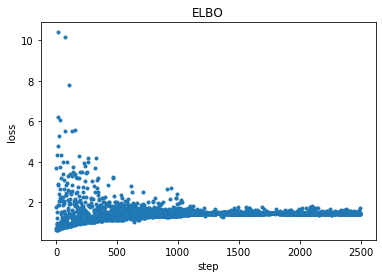

In [33]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses, '.')
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

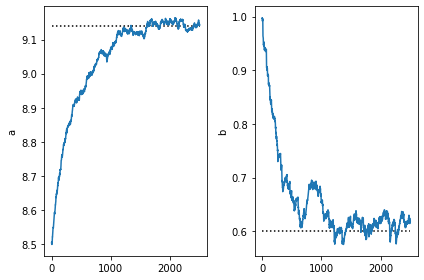

In [34]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()